In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib
import scipy
from scipy import stats
import numpy as np
import scipy
import matplotlib as mpl
from pathlib import Path

from matplotlib import cm
from collections import OrderedDict
from collections import namedtuple
from matplotlib import rc
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors

In [5]:
samples_file = Path('../data/feasible/samples/samples.txt')
data = np.loadtxt(samples_file,skiprows=1)

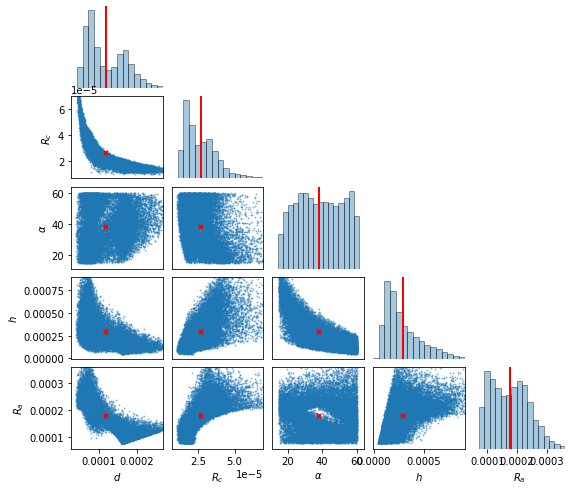

In [20]:
fig, axs, gs = scatter_matrix([data], hist_plot=False, gamma=0.4, labels=[r'$d$',r'$R_c$',r'$\alpha$', r'$h$', r'$R_a$'],\
                             specials=[{"vals":np.mean(data,axis=0),"color":'r'}])
fig.set_size_inches(7,7)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.1, hspace=0.1)

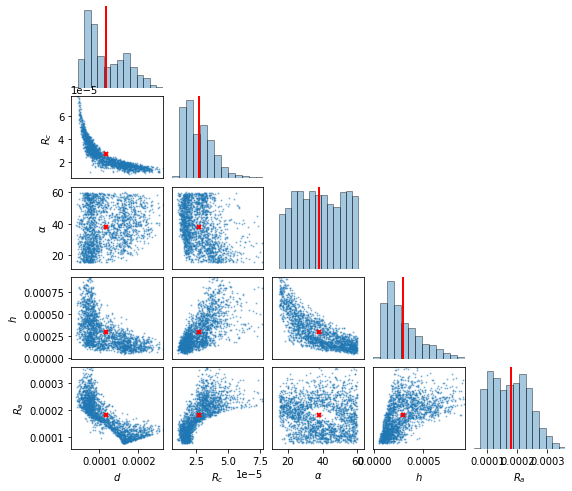

In [3]:
samples_file = Path('../data/feasible/test/samples/samples.txt')
data = np.loadtxt(samples_file,skiprows=1)

fig, axs, gs = scatter_matrix([data], hist_plot=False, gamma=0.4, labels=[r'$d$',r'$R_c$',r'$\alpha$', r'$h$', r'$R_a$'],\
                             specials=[{"vals":np.mean(data,axis=0),"color":'r'}])
fig.set_size_inches(7,7)
plt.subplots_adjust(left=0.01, right=0.99, wspace=0.1, hspace=0.1)

In [2]:
def scatter_matrix(samples, #list of chains
                   mins=None, maxs=None,
                   upper_right=None,
                   specials=None,
                   hist_plot=True, # if false then only data
                   nbins=200,
                   gamma=0.5,
                   labels=None):

    nchains = len(samples)
    dim = samples[0].shape[1]

    if mins is None:
        mins = np.zeros((dim))
        maxs = np.zeros((dim))

        for ii in range(dim):
            # print("ii = ", ii)
            mm = [np.quantile(samp[:, ii], 0.01, axis=0) for samp in samples]
            # print("\t mins = ", mm)
            mins[ii] = np.min(mm)
            mm = [np.quantile(samp[:, ii], 0.99, axis=0) for samp in samples]            
            # print("\t maxs = ", mm)
            maxs[ii] = np.max(mm)

            if specials is not None:
                if isinstance(specials, list):
                    minspec = np.min([spec['vals'][ii] for spec in specials])
                    maxspec = np.max([spec['vals'][ii] for spec in specials])
                else:
                    minspec = specials['vals'][ii]
                    maxspec = specials['vals'][ii]
                mins[ii] = min(mins[ii], minspec)
                maxs[ii] = max(maxs[ii], maxspec)
    

    deltas = (maxs - mins) / 10.0
    use_mins = mins - deltas
    use_maxs = maxs + deltas

    cmuse = cm.get_cmap(name='jet')

    # fig = plt.figure(constrained_layout=True)
    fig = plt.figure()
    if upper_right is None:
        gs = GridSpec(dim, dim, figure=fig)
        axs = [None]*dim*dim
        start = 0
        end = dim
        l = dim
    else:
        gs = GridSpec(dim+1, dim+1, figure=fig)
        axs = [None]*(dim+1)*(dim+1)
        start = 1
        end = dim + 1
        l = dim+1

    # print("mins = ", mins)
    # print("maxs = ", maxs)

    for ii in range(dim):
        # print("ii = ", ii)
        axs[ii] = fig.add_subplot(gs[ii+start, ii])
        ax = axs[ii]

        # Turn everythinng off
        if ii < dim-1:
            ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
        else:
            ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True)
            if labels:
                ax.set_xlabel(labels[ii])
            
        ax.tick_params(axis='y', left=False, right=False, labelleft=False)
        ax.set_frame_on(False)

        sampii = np.concatenate([samples[kk][:, ii] for kk in range(nchains)])
        # for kk in range(nchains):
        # print("sampii == ", sampii)
        ax.hist(sampii,            
                # ax.hist(samples[kk][:, ii],
                bins='sturges',
                density=True,
                edgecolor='black',
                stacked=True,
                range=(use_mins[ii],use_maxs[ii]),
                alpha=0.4)
        if specials is not None:
            for special in specials:
                if special['vals'][ii] is not None:
                    # ax.axvline(special[ii], color='red', lw=2)
                    if 'color' in special:
                        ax.axvline(special['vals'][ii], color=special['color'], lw=2)
#                         ax.axvline(special['vals2'][ii], color=special['color2'], lw=2)
                    else:
                        ax.axvline(special['vals'][ii], lw=2)

        ax.set_xlim((use_mins[ii]-1e-10, use_maxs[ii]+1e-10))

        for jj in range(ii+1, dim):
            # print("jj = ", jj)
            axs[jj*l + ii] = fig.add_subplot(gs[jj+start, ii])
            ax = axs[jj*l + ii]


            if jj < dim-1:
                ax.tick_params(axis='x', bottom=False, top=False, labelbottom=False)
            else:
                ax.tick_params(axis='x', bottom=True, top=False, labelbottom=True)
                if labels:
                    ax.set_xlabel(labels[ii])
            if ii > 0:
                ax.tick_params(axis='y', left=False, right=False, labelleft=False)
            else:
                ax.tick_params(axis='y', left=True, right=False, labelleft=True)
                if labels:
                    ax.set_ylabel(labels[jj])
                    
            ax.set_frame_on(True)     

            for kk in range(nchains):
                if hist_plot is True:
                    ax.hist2d(samples[kk][:, ii], samples[kk][:, jj],
                              bins=nbins,
                              norm=mcolors.PowerNorm(gamma),
                              density=True,
                              cmap=cmuse)
                else:
                    ax.plot(samples[kk][:, ii], samples[kk][:, jj], 'o', ms=1, alpha=gamma)

                # ax.hist2d(samples[kk][:, ii], samples[kk][:, jj], bins=nbins)

            if specials is not None:
                for special in specials:
                    if 'color' in special:
                        ax.plot(special['vals'][ii], special['vals'][jj], 'x',
                                color=special['color'], ms=4, mew=2)
#                         ax.plot(special['vals2'][ii], special['vals2'][jj], 'x',
#                                 color=special['color2'], ms=4, mew=2)
                    else:
                        ax.plot(special['vals'][ii], special['vals'][jj], 'x',
                                ms=4, mew=2)


            ax.set_xlim((use_mins[ii], use_maxs[ii]))
            ax.set_ylim((use_mins[jj]-1e-10, use_maxs[jj]+1e-10))



    plt.tight_layout(pad=0.01);
    if upper_right is not None:
        size_ur = int(dim/2)

        name = upper_right['name']
        vals = upper_right['vals']
        if 'log_transform' in upper_right:
            log_transform = upper_right['log_transform']
        else:
            log_transform = None
        ax = fig.add_subplot(gs[0:int(dim/2),
                                size_ur+1:size_ur+int(dim/2)+1])

        lb = np.min([np.quantile(val, 0.01) for val in vals])
        ub = np.max([np.quantile(val, 0.99) for val in vals])
        for kk in range(nchains):
            if log_transform is not None:
                pv = np.log10(vals[kk]) 
                ra = (np.log10(lb), np.log10(ub))
            else:
                pv = vals[kk]
                ra = (lb, ub)
            ax.hist(pv,
                    density=True,
                    range=ra,
                    edgecolor='black',
                    stacked=True,
                    bins='auto',
                    alpha=0.2)
        ax.tick_params(axis='x', bottom='both', top=False, labelbottom=True)
        ax.tick_params(axis='y', left='both', right=False, labelleft=False)
        ax.set_frame_on(True)
        ax.set_xlabel(name)
    plt.subplots_adjust(left=0.15, right=0.95)
    return fig, axs, gs
